In [10]:
"""
(Practical tip) Table of contents can be compiled directly in jupyter notebooks using the following code:
I set an exception: if the package is in your installation you can import it otherwise you download it 
then import it.
"""
try:
    from jyquickhelper import add_notebook_menu 
except:
    !pip install jyquickhelper
    from jyquickhelper import add_notebook_menu
    
"""
Output Table of contents to navigate easily in the notebook. 
For interested readers, the package also includes Ipython magic commands to go back to this cell
wherever you are in the notebook to look for cells faster
"""
add_notebook_menu()

## Imports

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
from sklearn.preprocessing import OneHotEncoder

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, TextVectorization, Embedding, Dense, Dropout, Activation
from tensorflow.keras.layers import TimeDistributed, LSTM
from tensorflow.keras.layers import Flatten, RepeatVector, Dot, Permute, AveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [14]:
!pip install tensorflow_addons

In [15]:
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score

## Load the dataset


In [16]:
TRAIN = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/train.csv.gz").fillna(value="")
VAL = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/val.csv.gz").fillna(value="")
TEST = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/test.csv.gz").fillna(value="")

TRAIN.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,Samsung Galaxy Note 4 N910C Unlocked Cellphone...,Samsung,449.99,4,I love it!!! I absolutely love it!! 👌👍,0.0
1,BLU Energy X Plus Smartphone - With 4000 mAh S...,BLU,139.0,5,I love the BLU phones! This is my second one t...,4.0
2,Apple iPhone 6 128GB Silver AT&T,Apple,599.95,5,Great phone,1.0
3,BLU Advance 4.0L Unlocked Smartphone -US GSM -...,BLU,51.99,4,Very happy with the performance. The apps work...,2.0
4,Huawei P8 Lite US Version- 5 Unlocked Android ...,Huawei,198.99,5,Easy to use great price,0.0


In [19]:
'''
#Use part of the dataset
TRAIN = TRAIN[:1000]
VAL = VAL[:500]
TEST = TEST[:500]
TRAIN.shape, VAL.shape, TEST.shape
'''

((1000, 6), (500, 6), (500, 6))

In [20]:
''' Construct X_train and y_train '''
X_train = np.array(TRAIN['Reviews']).reshape(-1,1)

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
y_train = ohe.fit_transform(np.array(TRAIN['Rating']).reshape(-1,1))

X_train.shape, y_train.shape

((1000, 1), (1000, 5))

In [21]:
''' Do the same for val '''
X_val = np.array(VAL['Reviews']).reshape(-1,1)
y_val = ohe.transform(np.array(VAL['Rating']).reshape(-1,1))

''' Do the same for test '''
X_test = np.array(TEST['Reviews']).reshape(-1,1)
y_test = ohe.transform(np.array(TEST['Rating']).reshape(-1,1))

##Build Model

Till now, we did some imports and load the dataset. We can build our model now. First we define the constants and vectorizer layer.

In hyper-parameter search in constants:

1. **learning rate:** I tested learning rate in the range [0.1, 0.01 and 0.001, 0.0001] and 0.001 gived the best result.

2. Vocab size is fixed to 10000 to get all the vocabulary in the reviews.
3. Embedding size is the output dimension of the dense embedding. It is fixed to 1000.
4. Recurrent size is the dimensionality of the output space. I tested it as 64 and 128 and recurrent_size = 64 got the higher result.
5. I tested drop out rate as 0.2 or 0.25 and decided to keep 0.25.

In [22]:
# Constants
nb_classes = y_train.shape[1]
vocab_size = 10000    # Maximum vocab size -- adjust with the size of the vocabulary
embedding_size = 1000 # Embedding size
recurrent_size = 64 # Recurrent size
hidden_size = recurrent_size//4    # Hidden layer
dropout_rate = 0.25   # Dropout rate for regularization
max_len = 1000         # Sequence length to pad the outputs to -- adjust with the distribution of the reviews length
learning_rate=0.001

Create vectorizer layer:

In [23]:
#vectorizer layer.
vectorize_layer = TextVectorization(max_tokens=vocab_size,
                                    standardize="lower_and_strip_punctuation",
                                    # it is possible to build your own function
                                    # to transform emoji into text
                                    # to transform foreign reviews in english one
                                    # etc.
                                    output_mode='int',
                                    output_sequence_length=max_len)

Fit vectorized layer on train

In [24]:
vectorize_layer.adapt(X_train)

## Attention with Bi-LSTM network



Using bi-lstm will create two copies of the hidden layer, one fit in the input sequences as-is and one on a reversed copy of the input sequence. By default, the output values from these LSTMs will be concatenated.

I used two Bidirectional LSTM cells to improve the performance. 


In [25]:
from keras.layers import Bidirectional


# ------------------------------------------------------
# MODEL BUILDING
# ------------------------------------------------------
def build_model():
    # Input: a review
    input_ = Input(shape=(1, ), name="input", dtype=tf.string)

    # Transform the review in a list of tokenID
    vect = vectorize_layer(input_)

    # Keras embedding
    embedding = Embedding(vocab_size,
                          embedding_size, 
                          weights=None,  # Without pre-learning
                          trainable=True,# Trainable
                          name='embedding'
                         )(vect)

    #Use two Bidirectional LSTM instead of one LSTM
    rnn = Bidirectional( LSTM(recurrent_size, return_sequences=True, 
               return_state=False,
               dropout=dropout_rate, recurrent_dropout=dropout_rate),
               
               merge_mode='concat')(embedding)

    rnn = Bidirectional( LSTM(recurrent_size, return_sequences=True, 
               return_state=False,
               dropout=dropout_rate, recurrent_dropout=dropout_rate),
               
               merge_mode='concat')(rnn)

    # Attention layer
    attention = Dense(1, activation='tanh')(rnn)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
  

    # To be able to multiply (scalar/vector KERAS)
    attention = RepeatVector(recurrent_size)(attention) # NORMAL RNN
    attention = Permute([2, 1])(attention)
  
    # Application of attention on the output of the RNN
    sent_representation = Dot(axes=1, normalize=False)([rnn, attention])
    
    # Flatten to enter the Dense
    flatten = Flatten()(sent_representation)
    
    # Dense for classification with 1 hidden layer
    hidden_dense = Dense(hidden_size, activation="relu")(flatten)
    hidden_dense = Dropout(dropout_rate)(hidden_dense)

    # Classification et ouput
    output_ = Dense(nb_classes, activation='softmax')(hidden_dense)
    
    # Build  model
    model = Model(inputs=input_, outputs=output_)
    
    return model

model = build_model()

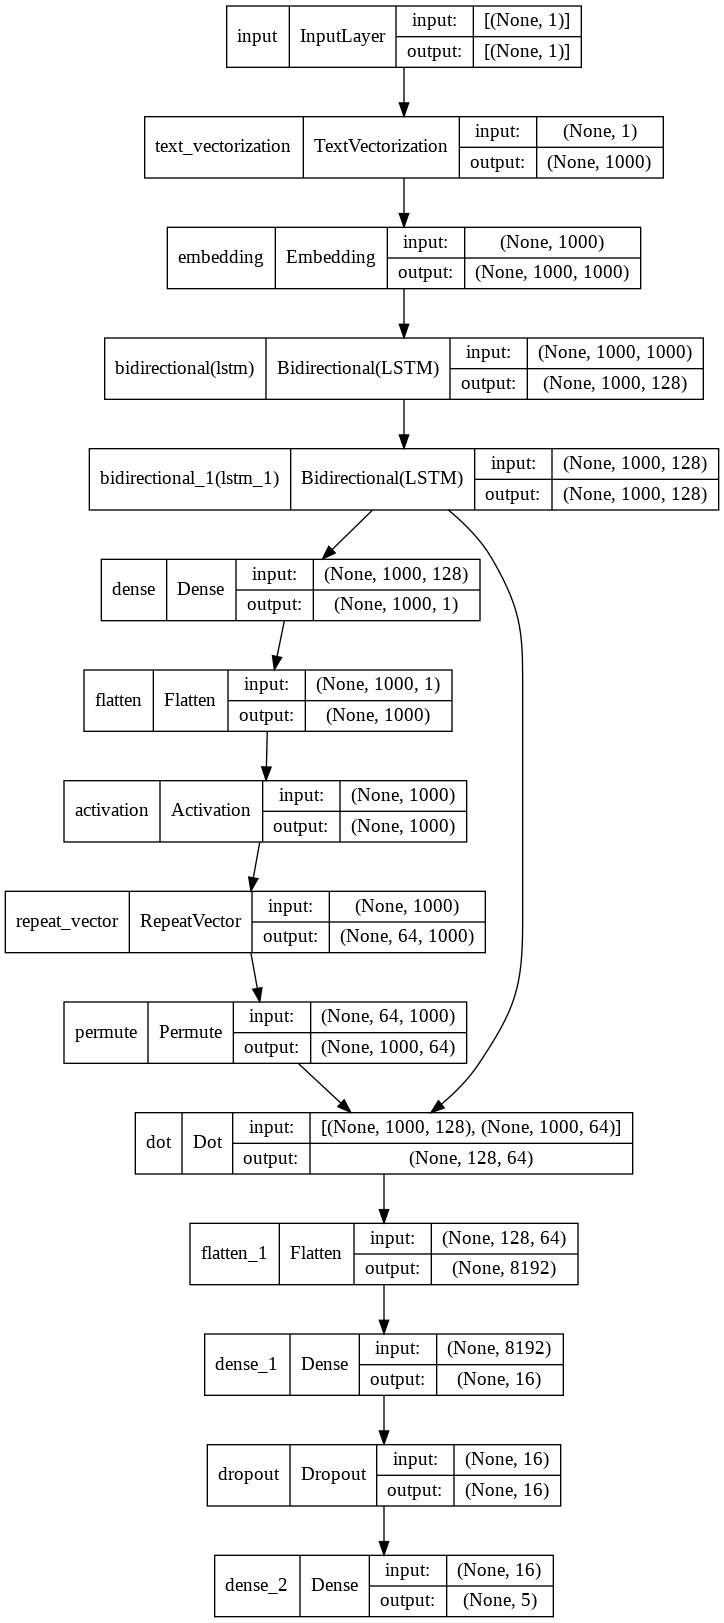

In [26]:
# Plot model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='LSTM_with_attention.png')

In [27]:
# Compile the model
f1 = F1Score(num_classes=nb_classes, average="macro", threshold=0.5)
op = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=op, loss='categorical_crossentropy', metrics=[f1])

In [28]:
# fit model using ealy stopping
es = EarlyStopping(monitor='val_f1_score', mode='max', patience=5, restore_best_weights=True, verbose=2)
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val), 
                    epochs=4000, callbacks=[es], verbose=1, shuffle=False)

Epoch 1/4000
32/32 [==============================] - 507s 15s/step - loss: 1.3618 - f1_score: 0.0999 - val_loss: 1.2811 - val_f1_score: 0.0000e+00
Epoch 2/4000
32/32 [==============================] - 488s 15s/step - loss: 1.2729 - f1_score: 0.1202 - val_loss: 1.2457 - val_f1_score: 0.1371
Epoch 3/4000
32/32 [==============================] - 498s 16s/step - loss: 1.1396 - f1_score: 0.1993 - val_loss: 1.5619 - val_f1_score: 0.1850
Epoch 4/4000
32/32 [==============================] - 501s 16s/step - loss: 0.9952 - f1_score: 0.2633 - val_loss: 1.2163 - val_f1_score: 0.2418
Epoch 5/4000
32/32 [==============================] - 520s 16s/step - loss: 0.8521 - f1_score: 0.3050 - val_loss: 1.1558 - val_f1_score: 0.2278
Epoch 6/4000
32/32 [==============================] - 522s 16s/step - loss: 0.7706 - f1_score: 0.3225 - val_loss: 1.1332 - val_f1_score: 0.2596
Epoch 7/4000
32/32 [==============================] - 528s 17s/step - loss: 0.7162 - f1_score: 0.3252 - val_loss: 1.1876 - val_f1_sc

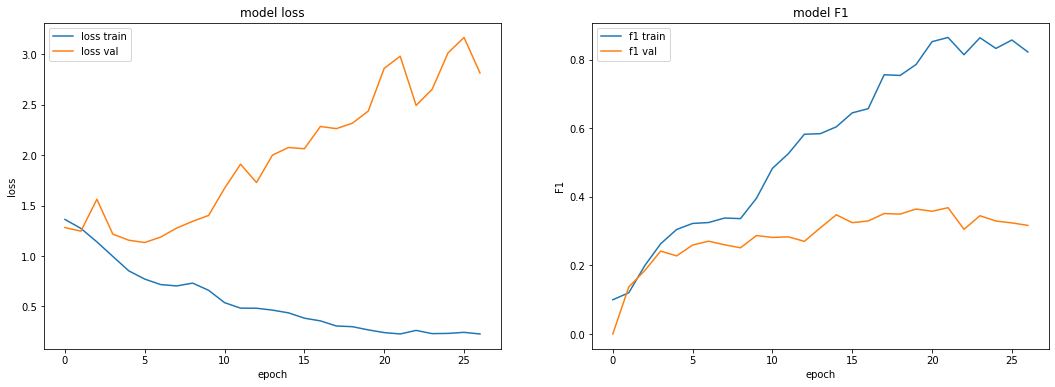

In [29]:
# plot history
def babysit(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

    # summarize history for loss
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('model loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['loss train', 'loss val'], loc='best')

    # summarize history for loss
    ax2.plot(history.history['f1_score'])
    ax2.plot(history.history['val_f1_score'])
    ax2.set_title('model F1')
    ax2.set_ylabel('F1')
    ax2.set_xlabel('epoch')
    ax2.legend(['f1 train', 'f1 val'], loc='best')

    plt.show()
    
babysit(history)

It takes a lot of time to fit the model with whole dataset. I used a part of the dataset at the begining for hyper-parameter search and debugging. This partipn is 1000 data points for training, 500 data points for testing and validation. I get F1 score of 0.72 with this partion.

In [1]:
# Evaluate the model
f1.update_state(y_test, model.predict(X_test))
print('F1: %f' % (f1.result().numpy()))

NameError: ignored